# ATIS Flight Reservations - Information Extraction


<hr>

Table of Contents:

1. Understanding the Data
2. Information Extraction 
    - Pipeline for Information Extraction Systems
    - Named Entity Recognition (NER)
3. Models for Entity Recognition
    - Rule-based models
        - Regular Expression Based Rules (ex)
        - Chunking 
    - Probabilistic models
        - Unigram and Bigram models
        - Naive Bayes Classifier 
        - Conditional Random Fields (CRFs)

<hr>

The ATIS (Airline Travel Information Systems) dataset consists of English language queries for booking (or requesting information about) flights in the US. 

Each word in a query (i.e. a request by a user) is labelled according to its **entity-type**, for e.g. in the query 'please show morning flights from chicago to new york', 'chicago' and 'new york are labelled as 'source' and 'destination' locations respectively while 'morning' is labelled as 'time-of-day' (the exact labelling scheme is a bit different, more on that later).

Some example queries taken from the dataset are shown below:

```
{
'what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisco',
 'what is the abbreviation for canadian airlines international',
 "i 'd like to know the earliest flight from boston to atlanta",
 'show me the us air flights from atlanta to boston',
 'show me the cheapest round trips from dallas to baltimore',
 "i 'd like to see all flights from denver to philadelphia"
 }
 ```

### Objective
Our objective is to **build an information extraction system** which can extract entities relevant for booking flights (such as source and destination cities, time, date, budget constraints etc.) in a **structured format** from a given user-generated query.

A structured format could be a dictionary, a JSON, etc. - basically anything that can be parsed and used for looking up relevant flights from a database.


### Downloads
The dataset is divided into five folds, each fold having a training, validation and test set.
You can download the dataset here: http://lisaweb.iro.umontreal.ca/transfert/lisa/users/mesnilgr/atis/




# Understanding the Data 

Let's understand the structure of the training data. The dataset is provided in five folds, each fold having a training, validation, test set and a dict (explained later). All folds are structurally identical, so understanding one fold is enough to understand the entire set.


In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random

import gzip, os, pickle # gzip for reading the gz files, pickle to save/dump trained model 
import _pickle as cPickle

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers

from nltk.corpus import conll2000
from nltk import conlltags2tree, tree2conlltags, ChunkParserI

from itertools import chain

# supress warnings
import warnings
warnings.filterwarnings('ignore')

Let's now read the first fold of the dataset. The data is in .gz files, so we'll need the gzip library as well. 

In [2]:
# read the first part of the dataset
# each part (.gz file) contains train, validation and test sets, plus a dict

filename = './data/atis.fold0.pkl.gz'
f = gzip.open(filename, 'rb')
try:
    train_set, valid_set, test_set, dicts = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set, dicts = pickle.load(f)
finally:
    f.close()


In [3]:
# type and size of the train set
print(type(train_set))
print()

# types of the three elements in the tuple
print(type(train_set[0]), type(train_set[1]), type(train_set[2]))
print(len(train_set[0]), len(train_set[1]), len(train_set[2]))

<class 'tuple'>

<class 'list'> <class 'list'> <class 'list'>
3983 3983 3983


The training set is a tuple containing three lists of same lengths as shown above. Similarly, the validation and test sets contain three lists as well (shown below).

In [4]:
# validation set
print(type(valid_set[0]), type(valid_set[1]), type(valid_set[2]))
print(len(valid_set[0]), len(valid_set[1]), len(valid_set[2]))
print()

# test set
print(type(test_set[0]), type(test_set[1]), type(test_set[2]))
print(len(test_set[0]), len(test_set[1]), len(test_set[2]))

<class 'list'> <class 'list'> <class 'list'>
995 995 995

<class 'list'> <class 'list'> <class 'list'>
893 893 893


Thus, we have the train, validation and test sets each containing three lists of different lengths. Now, let's understand the data stored in the three lists.

In [5]:
# first few elements in each list of the training set 
pprint.pprint(train_set[0][:3])
print('#'*50)
pprint.pprint(train_set[1][:3])
print('#'*50)
pprint.pprint(train_set[2][:3])

[array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205], dtype=int32),
 array([554, 241, 481,  14, 200,  91,  26, 239], dtype=int32),
 array([232,   0, 273, 502, 254, 481, 165, 193, 208,  77, 502,  64],
      dtype=int32)]
##################################################
[array([  0,   0,   0,  18,   0,   1,  52,   0,   0,  76,   0,   0,   0,
        18, 109], dtype=int32),
 array([  0,   0,   0,   0,   0,   6, 107, 107], dtype=int32),
 array([ 0,  0,  0,  0,  0,  0, 44,  0,  0, 18,  0, 18], dtype=int32)]
##################################################
[array([126, 126, 126,  48, 126,  36,  35, 126, 126,  33, 126, 126, 126,
        78, 123], dtype=int32),
 array([126, 126, 126, 126, 126,   2,  83,  83], dtype=int32),
 array([126, 126, 126, 126, 126, 126,  42, 126, 126,  48, 126,  78],
      dtype=int32)]


The first list contains the actual queries encoded by integers such as 554, 194, 268 ... and so on. For e.g. the first three integers 554, 194, 268 are encoded values of the words 'what', 'flights', 'leave' etc. 


The second list is to be ignored.

The third list contains the (encoded) label of each word (how to do these mappings is explained in detail below). Since the actual words are encoded by numbers, we have to decode them using the dicts provided. Let's first store the three lists into separate objects so we don't have to worry about indexing the lists.


In [6]:
# storing the three elements of the tuple in three objects 
# The '_' is a conventional variable in python used to store non-useful/dummy objects
train_x, _, train_label = train_set
val_x, _, val_label = valid_set
test_x, _, test_label = test_set

So now, for training, validation and test sets, we have the **encoded words and labels** stored in the lists (train_x, train_label), (val_x, val_label) and (test_x, test_label). The first list represents the actual words (encoded), and the other list contains their labels (again, encoded).

Let's now understand the structure of the lists.

In [7]:
# each list in the tuple is a numpy array (which us a complete sentence/query)
# printing first list in the tuple's first element
# each element represents a word of the query
# this translates to 'what flights leave atlanta ....'
train_x[0]

array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205], dtype=int32)

In [8]:
# labels are stored in the third list train_label
train_label[0]

array([126, 126, 126,  48, 126,  36,  35, 126, 126,  33, 126, 126, 126,
        78, 123], dtype=int32)

To map the integers to words, we need to use the dictionaries provided. The dicts ```words2idx``` and ```labels2idx``` map the numeric ids to the actual words and labels respectively.

In [9]:
# dicts to map numbers to words/labels
print(type(dicts))
print(dicts.keys())

<class 'dict'>
dict_keys(['labels2idx', 'tables2idx', 'words2idx'])


In [10]:
# storing labels and words in separate variables
# we'll need only two of these dicts - words and labels
words = dicts['words2idx']
labels = dicts['labels2idx']

In [11]:
# each key of 'words' is a word, each value its index
# printing some random key:value pairs of 'words'
random.sample(words.items(), 10)

[('much', 324),
 ('las', 260),
 ('many', 296),
 ('requesting', 402),
 ('also', 34),
 ('morning', 321),
 ('thursdays', 497),
 ('their', 482),
 ('c', 87),
 ('ord', 364)]

In [12]:
# now, we can map the numeric values v in a sentence with the k,v in the dict
# train_x contains the list of training queries; train_x[0] is the first query
# this is the first query
[k for val in train_x[0] for k,v in words.items() if v==val]

['what',
 'flights',
 'leave',
 'atlanta',
 'at',
 'about',
 'DIGIT',
 'in',
 'the',
 'afternoon',
 'and',
 'arrive',
 'in',
 'san',
 'francisco']

In [13]:
# let's look at the first few queries
sents = []
for i in range(30):
    sents.append(' '.join([k for val in train_x[i] for k,v in words.items() if v==val]))

sents

['what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisco',
 'what is the abbreviation for canadian airlines international',
 "i 'd like to know the earliest flight from boston to atlanta",
 'show me the us air flights from atlanta to boston',
 'show me the cheapest round trips from dallas to baltimore',
 "i 'd like to see all flights from denver to philadelphia",
 'explain fare code qx',
 "i 'd like a united airlines flight on wednesday from san francisco to boston",
 'what is the price of american airlines flight DIGITDIGIT from new york to los angeles',
 'what does the meal code s stand for',
 'what are all flights to denver from philadelphia on sunday',
 'what times does the late afternoon flight leave from washington for denver',
 'what flights are available monday from san francisco to pittsburgh',
 'what airlines have business class',
 'flights from atlanta to washington dc',
 'from new york to toronto on thursday morning',
 'show me all the direct

Similarly, we can map the encoded values of each word's label using the ```labels``` dict.

In [14]:
# labels dict contains IOB (inside-out-beginning) labelled entities
# printing some randomg k:v pairs 
random.sample(labels.items(), 25)

[('B-mod', 54),
 ('B-depart_date.date_relative', 25),
 ('B-arrive_time.time', 14),
 ('I-restriction_code', 113),
 ('I-transport_type', 125),
 ('B-return_date.day_name', 60),
 ('B-month_name', 55),
 ('B-arrive_time.period_of_day', 12),
 ('B-depart_time.end_time', 31),
 ('B-meal_description', 53),
 ('B-restriction_code', 58),
 ('I-flight_mod', 104),
 ('I-flight_number', 105),
 ('B-return_date.month_name', 62),
 ('B-stoploc.airport_code', 69),
 ('B-compartment', 19),
 ('I-depart_time.end_time', 96),
 ('B-depart_time.period_of_day', 33),
 ('B-depart_time.period_mod', 32),
 ('I-depart_date.day_number', 94),
 ('I-return_date.date_relative', 114),
 ('I-fromloc.city_name', 109),
 ('B-arrive_date.day_name', 6),
 ('I-depart_time.start_time', 98),
 ('B-arrive_time.end_time', 10)]

There are 127 classes of labels (including the 'O' - tokens that do not fall into any entity).

In [15]:
# number of labels
print(len(labels.keys()))

127


#### Reversing the Dictionaries

Since the dicts ```words``` and ```labels``` are key:value pairs of index:word/label, let's reverse the dicts so that we don't have to do a reverse lookup everytime.

In [16]:
# converting words_to_id to id_to_words
# and labels_to_id to id_to_labels
id_to_words = {words[k]:k for k in words}
id_to_labels = {labels[k]:k for k in labels}

Now we can print the words and corresponding labels simply by looking up the value of a numeric index of each word. Let's write a function which takes in an index and returns the corresponding query with its labels.

In [17]:
# takes in an integer index corresponding to a query 
# and returns a list of (word, label) pairs   
def print_query(index):
    w = [id_to_words[id] for id in train_x[index]]
    l = [id_to_labels[id] for id in train_label[index]]
    return list(zip(w, l))

In [18]:
# sample query
print_query(0)

[('what', 'O'),
 ('flights', 'O'),
 ('leave', 'O'),
 ('atlanta', 'B-fromloc.city_name'),
 ('at', 'O'),
 ('about', 'B-depart_time.time_relative'),
 ('DIGIT', 'B-depart_time.time'),
 ('in', 'O'),
 ('the', 'O'),
 ('afternoon', 'B-depart_time.period_of_day'),
 ('and', 'O'),
 ('arrive', 'O'),
 ('in', 'O'),
 ('san', 'B-toloc.city_name'),
 ('francisco', 'I-toloc.city_name')]

Also, some queries specify stopover cities, such as this.

In [19]:
# example query: stopover city
print_query(3443)

[('is', 'O'),
 ('there', 'O'),
 ('a', 'O'),
 ('flight', 'O'),
 ('between', 'O'),
 ('oakland', 'B-fromloc.city_name'),
 ('and', 'O'),
 ('boston', 'B-toloc.city_name'),
 ('with', 'O'),
 ('a', 'O'),
 ('stopover', 'O'),
 ('in', 'O'),
 ('dallas', 'B-stoploc.city_name'),
 ('fort', 'I-stoploc.city_name'),
 ('worth', 'I-stoploc.city_name'),
 ('on', 'O'),
 ('twa', 'B-airline_code')]

# Information Extraction 

**Information Extraction (IE)** refers to the task of extracting structured information from unstructured text data. In this case, we want to extract all pieces of information from a query which are useful in making a flight reservation, such as source and destination cities, date of travel, price range etc. 

Other examples of IE tasks are extracting information about stock market announcements from financial news (which could be useful for predicting stock prices etc.), extracting structured information from large corpora of documents such as encyclopedias, government documents etc. On wikipedia, for e.g., some structured information is shown on the right side of the pages:

<br><br><hr>
<img src='https://i.stack.imgur.com/oJumb.png'>
<br><br><hr>

Most IE tasks start with the task of **Named Entity Recognition (NER)** - identifying mentions of *entities* in the text. Loosely speaking, entities refer to names of people, organizations (e.g. Air India, United Airlines), places/cities (Mumbai, Chicago), dates and timepoints (May, Wednesday, morning flight), numbers of specific types (e.g. money - 5000 INR) etc.

The general process of information extraction is described below.



## Information Extraction Pipeline

Most IE pipelines start with the usual text preprocessing steps - sentence segmentation, word tokenisation and POS tagging. After preprocessing, the usual tasks are named entity recognition, and optionally relation recognition. 

Note that this is a generic pipeline, and you may make modifications according to the nature of your application. For example, you may add a 'spell check/correction layer' as the first preprocessing step if you expect some input data to have spelling errors.

A generic IE pipeline schema, taken from the official NLTK book, is shown below.

<br><br><hr>
<img src='https://www.nltk.org/images/ie-architecture.png'>
<br><br><hr>

### Preprocessing 

The usual preprocessing steps are - if the raw input data is in the form of paragraphs, it is converted into sentences using a **sentence segmenter**, then broken down into tokens using **tokenisation**, and finally each token is **POS tagged**.



### Named Entity Recognition (NER)

The labels corresponding to each word/token, as shown above, are of three types - I, O and B, which stand for inside, out and beginning (called **IOB tags**). This is a common way of labelling text data meant for NER tasks. The task of information extraction and named-entity recognition is explained in detail below. First, let's understand the task of NER and IOB labelling in detail.

Some example IOB tagged words are shown below:


In [20]:
# run multiple times to see samples
# randomly chosen sample IOB tagged queries from training data
i=random.randrange(len(train_x))
print_query(i)

[('what', 'O'),
 ('is', 'O'),
 ('the', 'O'),
 ('fare', 'O'),
 ('on', 'O'),
 ('november', 'B-depart_date.month_name'),
 ('seventh', 'B-depart_date.day_number'),
 ('going', 'O'),
 ('one', 'B-round_trip'),
 ('way', 'I-round_trip'),
 ('from', 'O'),
 ('pittsburgh', 'B-fromloc.city_name'),
 ('to', 'O'),
 ('philadelphia', 'B-toloc.city_name')]

In the query above, there are two named entities (cities) - san francisco and denver. 

Since san francisco comprises of two words, the first one is tagged *B-* and the second as *I-*. On the other hand, denver is only one word, so there's no *I-* tag. All the other words are not entities and are thus marked *O* (outside any entity).

The **NER task** is to **predict the IOB labels** of each word.

### NER as a Sequence-Labelling Task

The task of **training an NER system**, i.e. assigning an IOB label to each word, is a **sequence labelling task** similar to POS tagging. For sequence labelling, one can try rule-based models such as writing **regular-expression based rules** to extract entities, **chunking** patterns of POS tags into an 'entity chunk' etc. (we'll try some of these below)

One the other hand, one can use **probabilistic sequence labelling models** such as **HMMs**, the **Naive Bayes** classifier (classifying each word into one label class), **Conditional Random Fields (CRFs)** etc. 

Once the IOB tags of each word are predicted, we can **evaluate the model** using the usual metrics for multi-class classification models (num_classes = number of IOB tags).

In the upcoming sections, we will try some of these approaches and compare their performance.

# Models for Entity Recognition

In the following sections, we'll build a variety of models for entity recognition, i.e. to predict the sequence of IOB tag of words. We'll try the two broad approaches - **rule-based models** and **probabilistic models**. 

Before that, we need to do some basic preprocessing of the data. 

## Part of Speech Tagging

The usual preprocessing steps are sentence segmentation, tokenisation and POS tagging, but since in this case the raw data is already split into sentences (queries) and words, we only need to do POS tagging.

The function below takes in a list of (encoded) sentences, uses the dict ```id_to_words``` to decode the numeric to the corresponding word, and returns the POS tagged list of sentences.

In [21]:
# POS tagging sentences
# takes in a list of sentences and returns a list of POS-tagged sentences
# in the form (word, tag)
nltk.download("averaged_perceptron_tagger")

def pos_tag(sent_list):
    pos_tags = []    
    for sent in sent_list:
        tagged_words = nltk.pos_tag([id_to_words[val] for val in sent])
        pos_tags.append(tagged_words)
    return pos_tags

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mz195/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
# pos tagging train, validation and test sets
train_pos = pos_tag(train_x)
valid_pos = pos_tag(val_x)
test_pos = pos_tag(test_x)

In [23]:
# looking at tags of some randomly chosen queries
# notice that most cities after 'TO' are incorrectly tagged as VB
i = random.randrange(len(train_pos))
train_pos[i]

[('please', 'VB'),
 ('give', 'VB'),
 ('me', 'PRP'),
 ('ground', 'JJ'),
 ('transportation', 'NN'),
 ('information', 'NN'),
 ('between', 'IN'),
 ('dallas', 'NN'),
 ('fort', 'NN'),
 ('worth', 'JJ'),
 ('airport', 'NN'),
 ('and', 'CC'),
 ('downtown', 'NN'),
 ('dallas', 'NNS')]

**Problems with the NLTK Tagger**

Note that almost all city/airport names that come after 'to/TO' are tagges as verbs 'VB', which is clearly incorrect. This is because NLTK's built-in tagger is trained using the penntreebank dataset, and it takes 'to/TO' as a strong signal for a 'VB'.


In general, the performance of a POS tagger depends a lot on the data used to train it. There are alternatives to it - one, you can try using an alternative tagger such as the Stanford tagger, Spacy etc. (though note that getting them up and running in python may take a bit of time in installing dependencies/debugging etc.).

The other alternative (recommended as a quick fix) is to use a **backup tagger** within NLTK, i.e. manually specify a unigram/bigram tagger to be used, and backed up by the standard NLTK tagger. You can <a href="https://stackoverflow.com/questions/5919355/custom-tagging-with-nltk/5922373#5922373">learn how to do that here.</a>


### Creating 3-tuples of ```(word, pos, IOS_label)```
To train a model, we need the entity labels of each word along with the POS tags, for e.g. in this format:

```
('show', 'VB', 'O'),
('me', 'PRP', 'O'),
('the', 'DT', 'O'),
('cheapest', 'JJS', 'B-cost_relative'),
('round', 'NN', 'B-round_trip'),
('trips', 'NNS', 'I-round_trip'),
('from', 'IN', 'O'),
('dallas', 'NN', 'B-fromloc.city_name'),
('to', 'TO', 'O'),
('baltimore', 'VB', 'B-toloc.city_name')
```
<hr>

Let's convert the training, validation and test sentences to this form. Since we have already  done POS tagging of the queries, we'll write a function which takes queries in the form (word, pos_tag) and the labels as input, and returns the list of sentences in the form (word, pos_tag, iob_label).

In [24]:
# function to create (word, pos_tag, iob_label) tuples for a given dataset
def create_word_pos_label(pos_tagged_data, labels):
    iob_labels = []         # initialize the list of 3-tuples to be returned
    
    for sent in list(zip(pos_tagged_data, labels)):
        pos = sent[0]       
        labels = sent[1]    
        zipped_list = list(zip(pos, labels)) # [(word, pos), label]
        
        # create (word, pos, label) tuples from zipped list
        tuple_3 = [(word_pos_tuple[0], word_pos_tuple[1], id_to_labels[label]) 
                   for word_pos_tuple, label in zipped_list]
        iob_labels.append(tuple_3)
    return iob_labels

In [25]:
# printing some sample queries in the form (word, pos, label)
train_labels = create_word_pos_label(train_pos, train_label)
train_labels[4:6]

[[('show', 'VB', 'O'),
  ('me', 'PRP', 'O'),
  ('the', 'DT', 'O'),
  ('cheapest', 'JJS', 'B-cost_relative'),
  ('round', 'NN', 'B-round_trip'),
  ('trips', 'NNS', 'I-round_trip'),
  ('from', 'IN', 'O'),
  ('dallas', 'NN', 'B-fromloc.city_name'),
  ('to', 'TO', 'O'),
  ('baltimore', 'VB', 'B-toloc.city_name')],
 [('i', 'JJ', 'O'),
  ("'d", 'MD', 'O'),
  ('like', 'VB', 'O'),
  ('to', 'TO', 'O'),
  ('see', 'VB', 'O'),
  ('all', 'DT', 'O'),
  ('flights', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('denver', 'NN', 'B-fromloc.city_name'),
  ('to', 'TO', 'O'),
  ('philadelphia', 'VB', 'B-toloc.city_name')]]

In [26]:
# storing validation and test data as well as (word, pos, label)
valid_labels = create_word_pos_label(valid_pos, val_label)
test_labels = create_word_pos_label(test_pos, test_label)

Now that we have converted the queries in the form (word, pos, label), we can convert them into a **tree format** and observe the actual entities more clearly (rather than IOB labels). 

In general, IOB tagged sentences are represented in either of the two common formats - 1. The ```(word, pos, label)``` or the tagged list format or 2. The tree format. 

As we will see later, some built-in models/sequence taggers in NLTK need the data in the tree format.

### Converting List to Tree Format

Let's now convert the sentences into a tree format, which is needed by NLTK to train taggers. In NLTK, there are two main methods to convert between the two formats (the list of tags and tree) - ```conlltags2tree``` and ```tree2conlltags```.

In [27]:
# print a sample tree in tuple format
train_labels[3]

[('show', 'VB', 'O'),
 ('me', 'PRP', 'O'),
 ('the', 'DT', 'O'),
 ('us', 'PRP', 'B-airline_name'),
 ('air', 'NN', 'I-airline_name'),
 ('flights', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('atlanta', 'NN', 'B-fromloc.city_name'),
 ('to', 'TO', 'O'),
 ('boston', 'VB', 'B-toloc.city_name')]

In [28]:
# converting the sample sentence above to tree format
tree = conlltags2tree(train_labels[3])
print(tree)

(S
  show/VB
  me/PRP
  the/DT
  (airline_name us/PRP air/NN)
  flights/NNS
  from/IN
  (fromloc.city_name atlanta/NN)
  to/TO
  (toloc.city_name boston/VB))


The tree above shows three entities in the query - ```flight_mod earliest``` (earliest), ```fromloc.city_name``` (boston), ```toloc.city_name``` (atlanta).

Let's now convert all training sentences to trees.

In [29]:
# converting training, validation and test datasets to tree format
train_trees = [conlltags2tree(sent) for sent in train_labels]
valid_trees = [conlltags2tree(sent) for sent in valid_labels]
test_trees = [conlltags2tree(sent) for sent in test_labels]

In [30]:
# print some sample training trees
i=random.randrange(len(train_trees))
print(train_trees[i])

(S
  what/WP
  (flight_time times/VBZ)
  does/VBZ
  the/DT
  (depart_time.period_of_day late/JJ afternoon/NN)
  flight/NN
  leave/VBP
  from/IN
  (fromloc.city_name washington/NN)
  for/IN
  (toloc.city_name denver/NN))


Now that we have the queries in tree formats, we can build some models to extract entities.

## Rule-Based Models for Entity Recognition

The most basic rule-based system can be written using regular expressions. The idea is to manually identify patterns which indicate occurence of entities we are interested in, such as source and destination cities, mentions of dates and time, names of organisations (in this case airlines such as united airlines, american airlines etc.) and write regular expressions to match them.


### Chunking

Chunking is a way to identify meaningful sequences of tokens called chunks in a sentence. It is commonly used to identify sequences of nouns, verbs etc. For example, in the example sentence taken from the NLTK book: <br>

S = *"We saw the yellow dog"*

there are two **noun phrase chunks** as shown below. Each outer box represents a chunk.

<img src='https://www.nltk.org/book/tree_images/ch07-tree-1.png'>

The corresponding **IOB representation** of the same is as follows:

<img src='https://www.nltk.org/images/chunk-tagrep.png'>



Similarly, in our dataset, the following sentence contains chunks such as fromloc.city_name (san francisco), class_type (first class), depart_time.time (DIGITDIGIT noon) etc.


In [31]:
# sample chunks 
print(train_trees[3468])

(S
  show/VB
  me/PRP
  flights/NNS
  on/IN
  (depart_date.day_name sunday/NN)
  going/VBG
  from/IN
  (fromloc.city_name san/JJ francisco/NN)
  to/TO
  (toloc.city_name boston/VB)
  (flight_stop nonstop/JJ)
  (class_type first/JJ class/NN)
  leaving/NN
  (depart_time.time_relative after/IN)
  (depart_time.time DIGITDIGIT/NNP noon/NN))


There are various techniques for building chunkers, such as regex based, unigram and bigram chunkers etc.

### Regular Expression Based Chunkers

Regex based chunkers define what is called a **chunk grammar**. A **chunk grammar is a pattern of POS tags** which are likely to form a particular chunk (and thus POS tagging is a necessary preprocessing step for such chunkers). 

The example from the NLTK book defined a simple garmmar to identify noun phrase chunks:



In [32]:
# chunking example sentence
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN")]

Now, we **define a chunk grammar** to identify noun phrase chunks as follows: *A noun phrase chunk occurs when an optional determiner (DT) is followed by any number of adjectives (JJ) and then a noun (NN).*

In [33]:
# define chunk grammar to identify noun phrase chunks
# an optional determiner (DT), followed by any number of adjectives (JJ) 
# and then a noun (NN)
grammar = "NP_chunk: {<DT>?<JJ>*<NN>}"

We now use the ```nltk.RegexpParser``` to parse the given sentence. The output will be a tree which identifies the NP chunks.

In [34]:
# parse the sentence
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
print(result)

(S
  (NP_chunk the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP_chunk the/DT cat/NN))


The first NP chunk is 'the little yellow dog' and the second one is 'the cat'. One can also print the list representation of this tree as follows:

In [35]:
# list form of the tree
tree2conlltags(result)

[('the', 'DT', 'B-NP_chunk'),
 ('little', 'JJ', 'I-NP_chunk'),
 ('yellow', 'JJ', 'I-NP_chunk'),
 ('dog', 'NN', 'I-NP_chunk'),
 ('barked', 'VBD', 'O'),
 ('at', 'IN', 'O'),
 ('the', 'DT', 'B-NP_chunk'),
 ('cat', 'NN', 'I-NP_chunk')]

Similarly, we can write rules to identify entities in the airlines dataset. Before building any useful chunkers, let's first make a **baseline chunker** - one which assigns the label 'O' to every word and see its evaluation metrics. We can then compare the eventual models with this one. 

In [36]:
# baseline (dummy chunker)
# assigns 'O' to each word

grammar = ''

# initialise cp 
cp = nltk.RegexpParser(grammar)

# evaluate results against actual IOB labels
result = cp.evaluate(train_trees)
print(result)

ChunkParse score:
    IOB Accuracy:  63.8%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


An accuracy of 63.8% shows that about 63% words have the tag 'O', i.e. they do not fall in any chunk/entity. The other metrics are 0 since we did not predict any chunks at all.

Let's now look at a few sentences and try to identify patterns for the chunks ```fromloc.city_name``` and ```toloc.city_name``` (since these are the most common entities).

In [37]:
# sample queries 
print(train_trees[random.randrange(len(train_trees))])

(S
  all/DT
  flights/NNS
  from/IN
  (fromloc.city_name montreal/NN)
  (cost_relative less/JJR)
  than/IN
  (fare_amount DIGITDIGITDIGIT/CD dollars/NNS))


It is easy to see that a common pattern is *from city_1 to city_2*. The POS tag of from is 'IN', to is 'TO'. However, there's an interesting flaw in the tagger - most cities (city_2) after TO are tagged as as verb 'VB' (the nltk tagger uses 'TO' as a string signal for a verb).

Nevertheless, the pattern is ```from/IN city_1/JJ city_1/NN to/TO city_2/VB city_2/NN``` (you can try looking at multiple sentences and verify).

Let's define the grammar to identify the two types of chunks - ```fromloc.city_name``` and ```toloc.city_name```. The syntax is to simply write two regexes within the grammar, one for each, one after the other.

In [38]:
# grammar for source and destination city chunks
grammar = '''
fromloc.city_name: {<JJ>?<NN>}
toloc.city_name: {<VB><NN>?}
'''
cp = nltk.RegexpParser(grammar)
result = cp.evaluate(train_trees)
print(result)

ChunkParse score:
    IOB Accuracy:  65.2%%
    Precision:     31.7%%
    Recall:        40.9%%
    F-Measure:     35.7%%


The results are although better than the baseline model, they are still quite unimpressive. Notice that now precision, recall and f-score are non-zero, indicating that the chunker is able to identify at least some chunks correctly (in this case ```fromloc.city_name``` and ```toloc.city_name```).

We can add more regex patterns for other chunk types as well.

We can see that in this dataset, queries are quite complex (large variety of labels, sentence structures etc.) and thus it is extremely hard write hand-written rules to extract useful entities.

Thus, we need to train probabilistic models such as CRFs, HMMs etc. to tag each word with its corresponding entity label.


## Probabilistic Models for Entity Recognition

Let's experiment with a few different models for labelling words with named entities.


### Unigram Chunker

Let's now try a **unigram chunker**. A unigram chunker assigns the IOB label that is most likely for each POS tag.

The following code defines a class ```UnigramChunker``` which (on initialisation) first converts the tree form of a sentence to the list form (word, pos, label), extracts the (pos, label) pairs and computes the unigram probabilities ```P(label | pos)``` for each POS tag. It then simply assigns the label that is most likely for the POS tag.

The ```parse()``` method of the class takes a sentence in the form (word, pos) as the input, extracts only the pos tag from it, and uses the unigram tagger to assign the IOB label to each word. It then returns the sentence after converting it to a tree format.

Note that the unigram tagger, like the previous regex-based chunkers, *does not make use of the word itself but only the word's POS tag*.

In [39]:
# unigram chunker

class UnigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [40]:
# unigram chunker 
unigram_chunker = UnigramChunker(train_trees)
print(unigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  66.3%%
    Precision:     37.5%%
    Recall:        18.5%%
    F-Measure:     24.8%%


The accuracy, precision and recall have slightly improved compared to the previous regex-based  parser. 

Let's also look at what the unigram parser has learnt.

In [41]:
# printing the most likely IOB tags for each POS tag

# extract the list of pos tags
postags = sorted(set([pos for sent in train_trees for (word, pos) in sent.leaves()]))

# for each tag, assign the most likely IOB label
print(unigram_chunker.tagger.tag(postags))

[('CC', 'O'), ('CD', 'B-round_trip'), ('DT', 'O'), ('EX', 'O'), ('FW', 'B-fromloc.city_name'), ('IN', 'O'), ('JJ', 'O'), ('JJR', 'B-cost_relative'), ('JJS', 'B-cost_relative'), ('MD', 'O'), ('NN', 'O'), ('NNP', 'B-depart_time.time'), ('NNS', 'O'), ('PDT', 'O'), ('POS', 'O'), ('PRP', 'O'), ('PRP$', 'O'), ('RB', 'O'), ('RBR', 'B-cost_relative'), ('RBS', 'B-cost_relative'), ('RP', 'O'), ('TO', 'O'), ('VB', 'B-toloc.city_name'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'O'), ('WP', 'O'), ('WRB', 'O')]


The unigram tagger has learnt that most pos tags are indeed an 'O', i.e. don't form an entity. Some interesting patterns it has learnt are:
- JJR, JJS (relative adjectives), are most likely B-cost_relative (e.g. cheapest, cheaper)
- NNP is most likely to be B-depart_time.time

### Bigram Chunker

Let's try a bigram chunker as well - we just need to change the ```UnigramTagger``` to ```BigramTagger```. This works exactly like the unigram chunker, the only difference being that now the probability of a pos tag having a label is computed using the current and the previous POS tags, i.e. P(label | pos, prev_pos).

In [42]:
# bigram tagger

class BigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [43]:
# unigram chunker 
bigram_chunker = BigramChunker(train_trees)
print(bigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  70.6%%
    Precision:     43.5%%
    Recall:        38.8%%
    F-Measure:     41.0%%


The metrics have improved significantly from unigram to bigram, which is expected. However, there are still some major flaws in this approach to build chunkers, the main drawback being that the model *uses only the POS tag to assign the label, not the actual word itself*. 

It is likely that if a model can make use of the word itself apart from the POS tag, it should be able to learn more complex patterns needed for this task. 

In fact, apart from the word, we can extract a large number of other features, such as previous word, previous tag, whether the word is a numeric, whether the word is a city or an airline company etc.

Thus, in the following few sections, we'll extract a variety of features and build classifiers such as Naive Bayes using those features. 

Our first step in the direction of feature extraction will be to extract an feature which indicates whether a word is a city, state or county etc. Such features can be extracted by simply **looking up a gazetteer**.


### Using a Gazetteer to Lookup Cities and States

A gazetteer is a geographical directory which stores data regarding the names of geographical entities (cities, states, countries) and some other features related to the geographies. An example gazetteer file for the US is given below.

Data download URL: https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv


We'll write a simple function which takes a word as input and returns a tuple indicating **whether the word is a city, state or a county**.

In [44]:

# reading a file containing list of US cities, states and counties
us_cities = pd.read_csv("./data/us_cities_states_counties.csv", sep="|")
us_cities.head()


,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [45]:
# storing cities, states and counties as sets
cities = set(us_cities['City'].str.lower())
states = set(us_cities['State full'].str.lower())
counties = set(us_cities['County'].str.lower())

In [46]:
print(len(cities))
print(len(states))
print(len(counties))

18854
62
1932


In [47]:
# define a function to look up a given word in cities, states, county
def gazetteer_lookup(word):
    return (word in cities, word in states, word in counties)

In [48]:
# sample lookups
print(gazetteer_lookup('washington'))
print(gazetteer_lookup('utah'))
print(gazetteer_lookup('philadelphia'))


(True, True, True)
(False, True, True)
(True, False, True)


Now let's build some **classifiers for NER**, i.e. classification models which take in each word (i.e. its features) as input and predicts its IOB label.

## Classifiers for NER 

As discussed above, IOB tagging is a **sequence classification task** - given a sequence of words and pos tags, predict the IOB label of the word. 

One of the main advantages of classifier based chunkers is that we can use a variety of features which we think will be strong indicators of a word's IOB tag. 

For e.g. if a word is a state/city name such as 'boston', it is very likely an ```B-fromloc.city_name``` or ```B-toloc.city_name```. 

Similarly, we can expect that the **previous word and the previous POS tag** could help predict the IOB labels of a word; that **if a word is the first or the last in the sentence** may strongly help predict the IOB label, etc. 

Also, in all sequence classification tasks, one can use the **predicted labels of the previous words** as features (recall that HMMs compute transition probabilities).


The following code implements the Naive Bayes classifer which uses a variety of **word features** for classification. 

The function ```npchunk_features()```  takes in a sentence and  the word whose features are to be extracted (defined by its index i in the sentence) as input and returns a dictionary of word features as output. It also takes a ```history``` argument - a list of already predicted previous tags to the left of the target word, which is useful if you are using them as features.



In [49]:
# extracts features for the word at index i in a sentence 
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    return {"pos": pos, "prevpos": prevpos, 'word':word,
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2]}

Let's now look at word features of some example sentences.

In [50]:
# example sentence
sent_pos = train_pos[0]
sent_pos

[('what', 'WP'),
 ('flights', 'NNS'),
 ('leave', 'VBP'),
 ('atlanta', 'VBN'),
 ('at', 'IN'),
 ('about', 'RB'),
 ('DIGIT', 'NNP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('afternoon', 'NN'),
 ('and', 'CC'),
 ('arrive', 'NN'),
 ('in', 'IN'),
 ('san', 'JJ'),
 ('francisco', 'NN')]

In [51]:
# features for sentence sent_pos
# each word's features are stored in a dict
for i in range(len(sent_pos)):
    print(npchunk_features(sent_pos, i, history=[]))
    print(' ')

{'pos': 'WP', 'prevpos': '<START>', 'word': 'what', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNS', 'prevpos': 'WP', 'word': 'flights', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBP', 'prevpos': 'NNS', 'word': 'leave', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBN', 'prevpos': 'VBP', 'word': 'atlanta', 'word_is_city': True, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'VBN', 'word': 'at', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'RB', 'prevpos': 'IN', 'word': 'about', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNP', 'prevpos': 'RB', 'word': 'DIGIT', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'NNP', 'word': 'in', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'DT', '

Now, we define two classes ```ConsecutiveNPChunkTagger``` and ```ConsecutiveNPChunker```.

The ```__init__``` method of the ```ConsecutiveNPChunkTagger``` class creates the ```train_set``` which is a list of labelled training sentences. Each sentence is a list of tuples (featureset, tag) -  each tuple is the featureset (dict) of a word and its label. 

The list ```history``` contains the list of previously predicted IOB tags, i.e. tags to the left of the target word. We can only use IOB tags to the left of the target word since that's all the tags we have at the time of prediction.

The ```__init__``` method takes in an IOB tagged list of train_sents and loops through them. It first untags the IOB tags to generate (word, pos_tag) tuples stored in ```untagged_sent```. These tuples are used to compute the word features.

Then for each (word, IOB_tag) in ```tagged_sent```, it computes the word features and appends the feature dict and the tag to ```train_sents```. It further appends the IOB tag to ```history```.
 
The ```tag()``` method simply takes in a sentence as a list of words and predicts the IOB label of each word in the sentence.

The ```ConsecutiveNPChunker``` class does all the the uninteresting work of converting between tree-list-tree formats (since NLTK's builtin classifiers need the list format). It takes in a list of sentences as trees, converts each sentence to the list form, and then initialises its tagger using methods already defined in the ```ConsecutiveNPChunkTagger``` class. The ```parse``` method tags the sentence and returns it in the tree format since it is easier to print and read.



In [52]:
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [53]:
# training the chunker 
chunker = ConsecutiveNPChunker(train_trees)

In [54]:
# evaluate the chunker
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.3%%
    Recall:        81.8%%
    F-Measure:     78.4%%


The results have improved significantly compared to the basic unigram/bigram chunkers, and they may improve further if we create better features.

For example, if the word is 'DIGIT' (numbers are labelled as 'DIGIT' in this dataset), we can have a feature which indicates that (see example below). In this dataset, 4-digit numbers are encoded as 'DIGITDIGITDIGITDIGIT'.

In [55]:
# example of 'DIGITDIGITDIGIT'
train_pos[1326]

[('do', 'VBP'),
 ('you', 'PRP'),
 ('have', 'VB'),
 ('an', 'DT'),
 ('DIGITDIGITDIGIT', 'NNP'),
 ('flight', 'NN'),
 ('from', 'IN'),
 ('denver', 'NN'),
 ('to', 'TO'),
 ('san', 'VB'),
 ('francisco', 'NN')]

Let's add some of these features and see if the performance improves.

In [56]:
# extracts features for a given word i in a given sentence 
# history refers to the previous POS tags in the sentence
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    if i == len(sentence)-1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextword, nextpos = sentence[i+1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    # adding word_is_digit feature (boolean)
    return {"pos": pos, "prevpos": prevpos, 'word':word, 
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2],
           'word_is_digit': word in 'DIGITDIGITDIGIT', 
           'nextword': nextword, 
           'nextpos': nextpos}

In [57]:
# train and evaluate the chunker 
chunker = ConsecutiveNPChunker(train_trees)
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.9%%
    Recall:        85.1%%
    F-Measure:     80.3%%


We can also see the most informative features of the NLTK NB classifier.

In [58]:
# most top-N informative features
chunker.tagger.classifier.show_most_informative_features(5)

Most Informative Features
                     pos = 'JJS'          B-cost : O      =  14237.4 : 1.0
                    word = 'after'        B-depa : O      =   5457.6 : 1.0
           word_is_digit = True           B-depa : O      =   5138.3 : 1.0
                    word = 'pm'           I-depa : O      =   4549.1 : 1.0
                    word = 'DIGIT'        B-depa : O      =   3148.4 : 1.0


We can see that some informative features are ```pos```, ```word```, ```word_is_digit``` etc.

When pos=JJS (superlative adjective e.g. *"cheapest"*), the ratio of probability of the labels ```B-cost:O``` is about 14237:1. Similarly, the features ```word``` and ```word_is_digit``` are very strong indicators of the labels ```B-depa``` and ```I-depa``` (departure time e.g. *"after DIGIT pm"*).

We can also try other classifiers that come with NLTK - let's try building a **decision tree**.

In [59]:
# Decision Tree Classifier
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.DecisionTreeClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [60]:
# train and evaluate the decision tree chunker
tree_chunker = ConsecutiveNPChunker(train_trees)
print(tree_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  94.9%%
    Precision:     83.9%%
    Recall:        87.2%%
    F-Measure:     85.5%%


The performance of decision trees is much better compared to the Naive Bayes classifier. We can of course also tune the decision tree hyperparameters (maxdepth, num_leaves, min_sample_split etc.), but we'll skip that for now.

Having tried some classification models, let us now try another extremely useful and popular model for sequence classification - **conditional random fields**.

## Conditional Random Fields (CRF)


Let's now build a CRF classifier. In sklearn, CRFs are implemented in the library ```sklearn_crfsuite```.

Let's define a function to extract features from a given sentence. This is similar to the ```npchunk_features()``` function defined above, but we'll add some new features as well such as the **suffix** of the word (upto the last 4 characters), **prefix** (upto first 4 characters) etc.

The list of features we'll extract is as follows:
```
{
            'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 

}
```



In [62]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
    
    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # word is in gazetteer
    gazetteer = gazetteer_lookup(word)
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    return {'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 }  

In [63]:
# example features: third word of the first training sentence
word_features(train_labels[0], i=3)

{'word': 'atlanta',
 'pos': 'VBN',
 'prevword': 'leave',
 'prevpos': 'VBP',
 'nextword': 'at',
 'nextpos': 'IN',
 'word_is_city': True,
 'word_is_state': False,
 'word_is_county': False,
 'word_is_digit': False,
 'suff_1': 'a',
 'suff_2': 'ta',
 'suff_3': 'nta',
 'suff_4': 'anta',
 'pref_1': 'a',
 'pref_2': 'at',
 'pref_3': 'atl',
 'pref_4': 'atla'}

Let's now write some functions to convert the training, validation and test datasets to the format required by the sklearn CRF classifier. The structure of the training sentences is as given below.

In [64]:
# structure of train/validation data
train_labels[0]

[('what', 'WP', 'O'),
 ('flights', 'NNS', 'O'),
 ('leave', 'VBP', 'O'),
 ('atlanta', 'VBN', 'B-fromloc.city_name'),
 ('at', 'IN', 'O'),
 ('about', 'RB', 'B-depart_time.time_relative'),
 ('DIGIT', 'NNP', 'B-depart_time.time'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('afternoon', 'NN', 'B-depart_time.period_of_day'),
 ('and', 'CC', 'O'),
 ('arrive', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('san', 'JJ', 'B-toloc.city_name'),
 ('francisco', 'NN', 'I-toloc.city_name')]

We'll define three functions below - ```sent2features()``` creates word features for each word in a given sentence while ```sent2labels``` extracts the label of each word in a given sentence.

In [65]:
# defining a few more functions to extract featrues, labels, words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

Now, let's convert the training data into a standard format - ```X_train``` is a list of sentences, where each sentence is a list of word_features (dicts). The list ```y_train``` is a list of sentences, each sentence further being a list of labels.

In [66]:
 # create training, validation and test sets
X_train = [sent2features(s) for s in train_labels]
y_train = [sent2labels(s) for s in train_labels]

X_valid = [sent2features(s) for s in valid_labels]
y_valid = [sent2labels(s) for s in valid_labels]

X_test = [sent2features(s) for s in test_labels]
y_test = [sent2labels(s) for s in test_labels]

In [67]:
# X_train is a list of sentences within which each feature has a corresponding dict of features
# first few words (each word has a feature dict) of the first sentence in X_train
X_train[0][:2]

[{'word': 'what',
  'pos': 'WP',
  'prevword': '<START>',
  'prevpos': '<START>',
  'nextword': 'flights',
  'nextpos': 'NNS',
  'word_is_city': False,
  'word_is_state': False,
  'word_is_county': False,
  'word_is_digit': False,
  'suff_1': 't',
  'suff_2': 'at',
  'suff_3': 'hat',
  'suff_4': 'what',
  'pref_1': 'w',
  'pref_2': 'wh',
  'pref_3': 'wha',
  'pref_4': 'what'},
 {'word': 'flights',
  'pos': 'NNS',
  'prevword': 'what',
  'prevpos': 'WP',
  'nextword': 'leave',
  'nextpos': 'VBP',
  'word_is_city': False,
  'word_is_state': False,
  'word_is_county': False,
  'word_is_digit': False,
  'suff_1': 's',
  'suff_2': 'ts',
  'suff_3': 'hts',
  'suff_4': 'ghts',
  'pref_1': 'f',
  'pref_2': 'fl',
  'pref_3': 'fli',
  'pref_4': 'flig'}]

In [68]:
# labels of the first sentence
y_train[0]

['O',
 'O',
 'O',
 'B-fromloc.city_name',
 'O',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'O',
 'O',
 'B-depart_time.period_of_day',
 'O',
 'O',
 'O',
 'B-toloc.city_name',
 'I-toloc.city_name']

Let's now fit a CRF with arbitrary hyperparameters. 

In [69]:
# fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.01, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

Let's now remove the label 'O' from the list of labels (can be accessed through ```crf.classes_```). This is because we'll only measure the metrics for other less frequent classes.

In [70]:
# remove 'O' from the labels
labels = list(crf.classes_)
labels.remove('O')
labels[:5]

['B-fromloc.city_name',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'B-depart_time.period_of_day',
 'B-toloc.city_name']

Now let's make predictions using the validation data and evaluate model performance. The metric we'll use for evaluation is ```flat_f1_score``` which is a weighed average of each class' f1-scores.

In [71]:
# make predictions 
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9372302908496231

The overall score does not give a detailed picture of how respective classes are performing. For e.g. we'd want to know how many ```fromloc.city_name``` and ```toloc.city_name``` are correctly identified. 

We can see the class-wise evaluation metrics using sklearn's ```classification_report```. The metrics precision, recall and f1-score are as usual, while support represents the number of instances of the respective class in the training data.

In [72]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

                              precision    recall  f1-score   support

             B-aircraft_code      1.000     1.000     1.000         3
              B-airline_code      1.000     0.963     0.981        27
              B-airline_name      1.000     0.993     0.996       139
              I-airline_name      1.000     0.975     0.987        80
              B-airport_code      1.000     0.800     0.889         5
              B-airport_name      0.600     0.429     0.500         7
              I-airport_name      0.600     0.333     0.429         9
 B-arrive_date.date_relative      1.000     1.000     1.000         1
      B-arrive_date.day_name      0.400     0.143     0.211        14
    B-arrive_date.day_number      0.600     0.353     0.444        17
    I-arrive_date.day_number      0.000     0.000     0.000         2
    B-arrive_date.month_name      0.600     0.353     0.444        17
      B-arrive_time.end_time      1.000     0.429     0.600         7
      I-arrive_time

The classification report tells us that:
- The overall f1-score (a weighted average of overall precision and recall) is 93.7%
- The *important* classes, i.e. those with high frequency such as ```B-fromloc.city_name```, ```B-toloc.city_name```, ```B-depart_date.day_name``` etc. are performing well

Let's now try tuning the hyperparameters of CRF using grid search CV.

In [73]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [74]:
# instantiate a GridSearchCV object
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=-1,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  6.9min finished


GridSearchCV(cv=3,
             estimator=CRF(algorithm='lbfgs', all_possible_transitions=True,
                           keep_tempfiles=None, max_iterations=100),
             n_jobs=-1, param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
             return_train_score=True,
             scoring=make_scorer(flat_f1_score, average=weighted, labels=['B-fromloc.city_name', 'B-depart_time.time_relative', 'B-depart_time.time', 'B-depart_time....name', 'B-month_name', 'B-day_number', 'B-depart_date.year', 'I-arrive_date.day_number', 'B-period_of_day', 'B-time_relative', 'B-time', 'I-time', 'I-flight_mod', 'B-return_date.day_name', 'I-fare_basis_code', 'I-depart_date.today_relative', 'B-stoploc.state_code', 'I-arrive_time.start_time', 'B-state_name', 'I-today_relative', 'B-stoploc.airport_name']),
             verbose=1)

In [75]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,83.163710,7.842350,0.494796,0.026779,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.930426,0.922370,0.934504,0.929100,0.005042,4,0.978361,0.980400,0.979812,0.979525,0.000857
1,82.985665,8.374674,0.523766,0.032698,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",0.930870,0.926590,0.934779,0.930746,0.003344,2,0.975267,0.977576,0.977806,0.976883,0.001147
2,83.350375,8.292046,0.523536,0.017986,0.01,1,"{'c1': 0.01, 'c2': 1}",0.920278,0.913100,0.918695,0.917358,0.003079,7,0.950655,0.949025,0.949209,0.949630,0.000729
3,83.290344,8.584179,0.459129,0.019482,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",0.931663,0.923990,0.935359,0.930338,0.004735,3,0.978314,0.979166,0.979282,0.978921,0.000432
4,81.965045,8.081670,0.464700,0.018835,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",0.932268,0.926484,0.936914,0.931889,0.004267,1,0.973995,0.975931,0.976143,0.975356,0.000967
5,82.582656,7.990042,0.497768,0.013172,0.1,1,"{'c1': 0.1, 'c2': 1}",0.917787,0.912097,0.918497,0.916127,0.002864,8,0.948426,0.947578,0.947646,0.947883,0.000385
6,81.303436,8.136291,0.425250,0.009548,1,0.01,"{'c1': 1, 'c2': 0.01}",0.917660,0.920771,0.922260,0.920230,0.001916,5,0.949051,0.950010,0.949515,0.949525,0.000392
7,81.365551,8.469283,0.405673,0.015251,1,0.1,"{'c1': 1, 'c2': 0.1}",0.914650,0.918630,0.922353,0.918544,0.003145,6,0.945374,0.948256,0.944271,0.945967,0.001680
8,72.841418,3.644624,0.383493,0.013796,1,1,"{'c1': 1, 'c2': 1}",0.905066,0.905441,0.901998,0.904168,0.001542,9,0.928574,0.931405,0.925755,0.928578,0.002306


In [77]:
cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_c1', 'param_c2', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

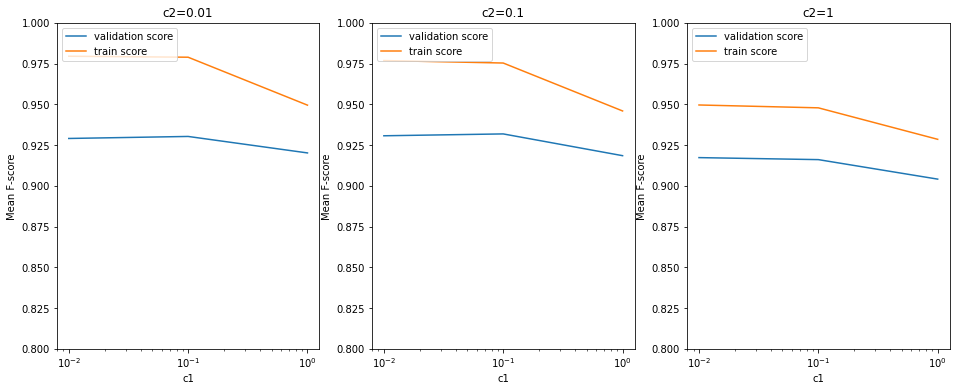

In [78]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_test_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')

The plot above shows that at very low values of c_1, the model overfits, as shown by the difference in training and test performance. Also, the test score seems to be slightly higher for c_2 = 0.1.

Let's thus choose c_1 = 0.1 and c_2 = 0.1. 

In [79]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

Having tuned the model, we can now save (dump) it to a a pickle file so that we can simply import it and use later for predictions.

In [80]:
# save the model to a pickle file
with open('tuned_crf_classifier.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close()   